## **Mount google drive**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
train_path = "drive/My Drive/data/train.csv"
test_path = "drive/My Drive/data/test.csv"

# **Exploratory Data Analysis & Data Pre Processing**


## **Importing necessary libraries**

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Loading Data Modelling Libraries

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier ,RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier 


from sklearn import metrics
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import unicodedata
from wordcloud import WordCloud
from nltk.corpus import stopwords
import string 
from nltk.stem import WordNetLemmatizer
import re
import copy

from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE

from google.colab import files

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Task - 1 : Load and Prepare dataset

In [0]:
def read_data(filepath):
    df = pd.read_csv(filepath, encoding = 'UTF-8')
    return df

train_data = read_data(train_path)
test_data  = read_data(test_path)
print("train.shape: {} \ntest.shape: {}".format(train_data.shape, test_data.shape))

train.shape: (7274, 3) 
test.shape: (1819, 2)


In [0]:
train = copy.deepcopy(train_data)
test  = copy.deepcopy(test_data)

print("Null-test",test.isnull().sum().sum())
print("Null-train",train.isnull().sum().sum())

Null-test 0
Null-train 1


In [0]:
train.dropna(inplace=True)

In [0]:
train.head()

,tweet_id,tweet,sentiment
0,1701,#sxswnui #sxsw #apple defining language of tou...,1
1,1851,Learning ab Google doodles! All doodles should...,1
2,2689,one of the most in-your-face ex. of stealing t...,2
3,4525,This iPhone #SXSW app would b pretty awesome i...,0
4,3604,Line outside the Apple store in Austin waiting...,1


In [0]:
test.head()

,tweet_id,tweet
0,7506,Audience Q: What prototyping tools do you use?...
1,7992,At SXSW? Send Your Best Photos &amp; Videos to...
2,247,@mention and here's a pic of you winning your...
3,7688,Google Marissa Mayer: mobile phone as a cursor...
4,3294,#SXSW Google maps is even cooler than I thought


In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7273 entries, 0 to 7273
Data columns (total 3 columns):
tweet_id     7273 non-null int64
tweet        7273 non-null object
sentiment    7273 non-null int64
dtypes: int64(2), object(1)
memory usage: 227.3+ KB


In [0]:
train.drop(['tweet_id'],axis=1, inplace=True)
test.drop(['tweet_id'],axis=1, inplace=True)

In [0]:
train[train['sentiment']==0].sample(2)

,tweet,sentiment
6245,RT @mention Just read that #apple will be at #...,0
6487,Aron Pilhofer of the New York Times and design...,0


In [0]:
train[train['sentiment']==1].sample(2)

,tweet,sentiment
3179,Has anyone seen the pop up stores in Austin li...,1
6213,"Yes, there's a line in front of the all-but-co...",1


In [0]:
train[train['sentiment']==2].sample(2)

,tweet,sentiment
2339,#sxsw: @mention intrvw @mention &quot;Govt is ...,2
4977,"Saw giant line, thought it was for movie premi...",2


In [0]:
train[train['sentiment']==3].sample(2)

,tweet,sentiment
2402,RT @mention Has spontaniety in life been repla...,3
4378,Gave into extreme temptation at #SXSW and boug...,3


## **Check for Class Imbalance**

Counter({1: 4310, 2: 2382, 0: 456, 3: 125})


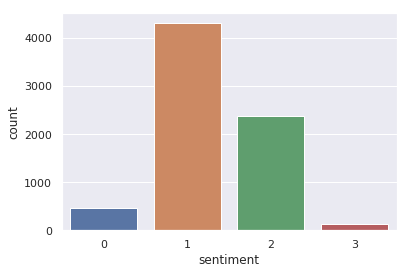

In [0]:
import collections
sentiment_counter = collections.Counter(train['sentiment'])
print(sentiment_counter)

sns.set(style="darkgrid")
ax = sns.countplot(x="sentiment", data=train)

# **Data Visualization**

wordcloud for sentiments  0


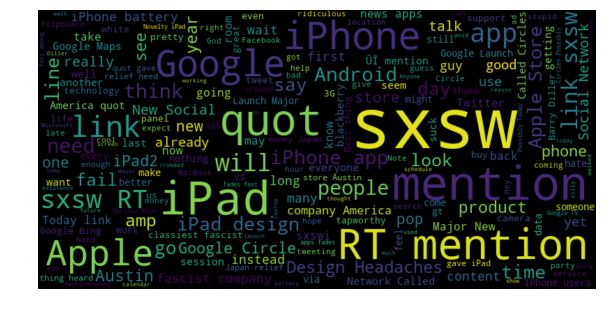

wordcloud for sentiments  1


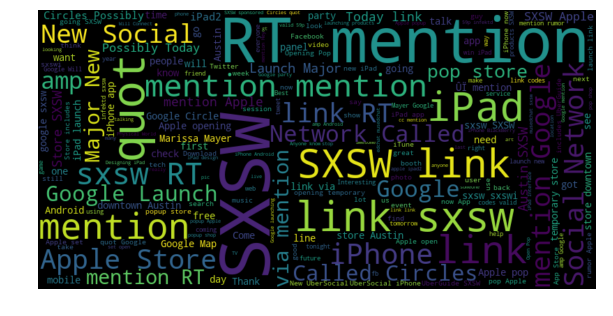

wordcloud for sentiments  2


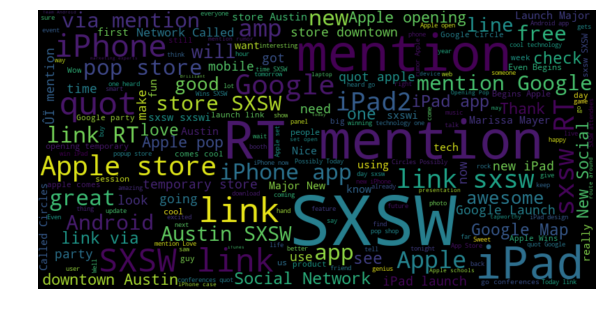

wordcloud for sentiments  3


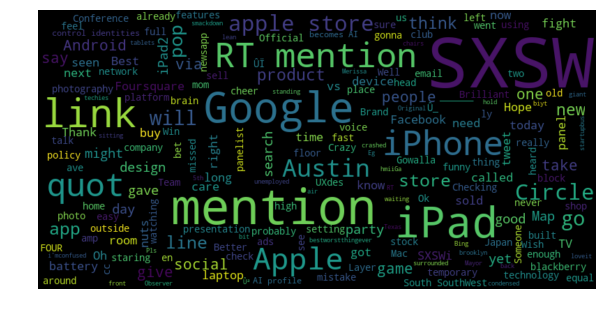

In [0]:
def create_wordcloud(sentiments):
  wordcloud = WordCloud(background_color='black',
                max_words = 200, max_font_size = 100, 
                random_state = 17, width=800, height=400)
  
  for i in range(len(sentiments)):
    print("wordcloud for sentiments ", i)
    wordcloud.generate(sentiments[i])
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

sentiment_negative = ' '.join([text for text in train_tweet.loc[train_tweet['sentiment'] == 0, 'tweet']])
sentiment_neutral  = ' '.join([text for text in train_tweet.loc[train_tweet['sentiment'] == 1, 'tweet']])
sentiment_positive = ' '.join([text for text in train_tweet.loc[train_tweet['sentiment'] == 2, 'tweet']])
sentiment_unknown  = ' '.join([text for text in train_tweet.loc[train_tweet['sentiment'] == 3, 'tweet']])

sentiments = [sentiment_negative, sentiment_neutral, sentiment_positive, sentiment_unknown]

create_wordcloud(sentiments)

## **Preprocess Data**

In [0]:
newStopWords = ['rt','mention','link','video','cont','in','get','via']
stop_words.extend(newStopWords)

def feature_engineering(dataframe):
  df = dataframe
  
  # number of punctuations
  df['num_punc'] = df['tweet'].apply(lambda tweet_msg: len([punct for punct in tweet_msg if punct in punctuation]))

  # Finding the number of words in the headline
  df['num_words'] = df['tweet'].apply(lambda tweet_msg: len(tweet_msg.split()))

  # the unique number of words in the headline
  df['num_unique_words'] = df['tweet'].apply(lambda tweet_msg: len(set(tweet_msg.split())))

  # the number of characters in the headline
  df['num_chars'] = df['tweet'].apply(lambda tweet_msg: len(tweet_msg))

  # number of genuine words with no stopwords  
  df['num_words_nostop'] = df['tweet'].apply(lambda tweet_msg: len([word for word in tweet_msg.split() if word not in stop_words]))

  # number of stopwords
  df['num_stop'] = df['num_words'] - df['num_words_nostop']
  
  return df

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

def preprocess(dataframe):
    dataframe['cleaned'] = dataframe['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))
    dataframe['cleaned'] = dataframe['cleaned'].str.replace('(\w+:\/\/\S+)|^rt|http.+?|[^\w\s]','')
    dataframe['cleaned'] = np.vectorize(remove_pattern)(dataframe['cleaned'], "@[\w]*")
    dataframe['cleaned'] = np.vectorize(remove_pattern)(dataframe['cleaned'], "\d*")

    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda row: nltk.word_tokenize(row))
    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda row: [word for word in row if word not in stop_words])
    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda row: [word for word in row if word not in string.punctuation])
    lemmatizer = WordNetLemmatizer()
    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda x: ' '.join(x))
    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda x:unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore'))
    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))
    return dataframe 

In [0]:
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

data['hashtags'] = hashtag_extract(data['tweet'])

Unigram Bigram Trigram

In [0]:
sent_0=data[data.sentiment == 0]
sent_1=data[data.sentiment == 1]
sent_2=data[data.sentiment == 2]
sent_3=data[data.sentiment == 3]

In [0]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(sent_0['other'], 20)
df1 = pd.DataFrame(common_words, columns = ['other' , 'count'])

Text(0.5, 1.0, 'Top 20 words in the Tweets')

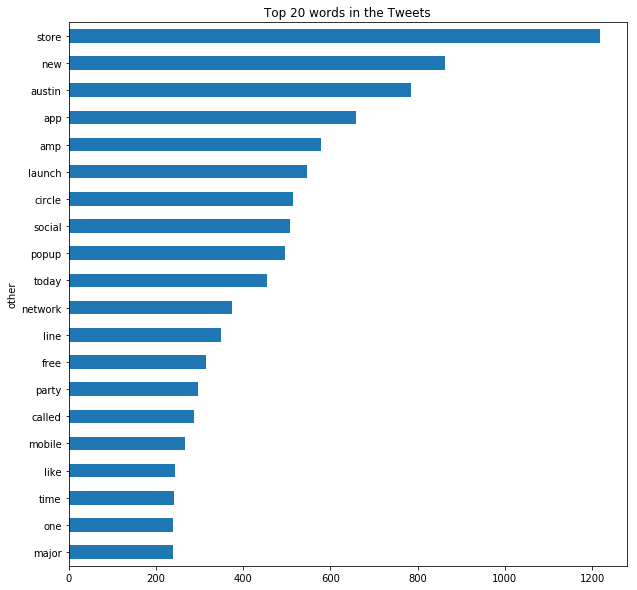

In [0]:
common_words = get_top_n_words(data['other'], 20)
df1 = pd.DataFrame(common_words, columns = ['other' , 'count'])
f, ax = plt.subplots(figsize=(10, 10))
plt.title('Top 20 words in the Tweets')
df1.groupby('other').sum()['count'].sort_values().plot(kind='barh')

In [0]:
common_words = get_top_n_words(sent_0['other'], 20)
df1 = pd.DataFrame(common_words, columns = ['other' , 'count'])
f, ax = plt.subplots(figsize=(10, 10))
plt.title('Top 20 words in sentimental 0')
df1.groupby('other').sum()['count'].sort_values().plot(kind='barh')

In [0]:
common_words = get_top_n_words(sent_1['other'], 20)
df1 = pd.DataFrame(common_words, columns = ['other' , 'count'])
f, ax = plt.subplots(figsize=(10, 10))
plt.title('Top 20 words in sentimental 1')
df1.groupby('other').sum()['count'].sort_values().plot(kind='barh')

In [0]:
common_words = get_top_n_words(sent_0['other'], 20)
df1 = pd.DataFrame(common_words, columns = ['other' , 'count'])
f, ax = plt.subplots(figsize=(10, 10))
plt.title('Top 20 words in sentimental 0')
df1.groupby('other').sum()['count'].sort_values().plot(kind='barh')

In [0]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

Text(0.5, 1.0, 'Top 20 words in sentimental Negative')

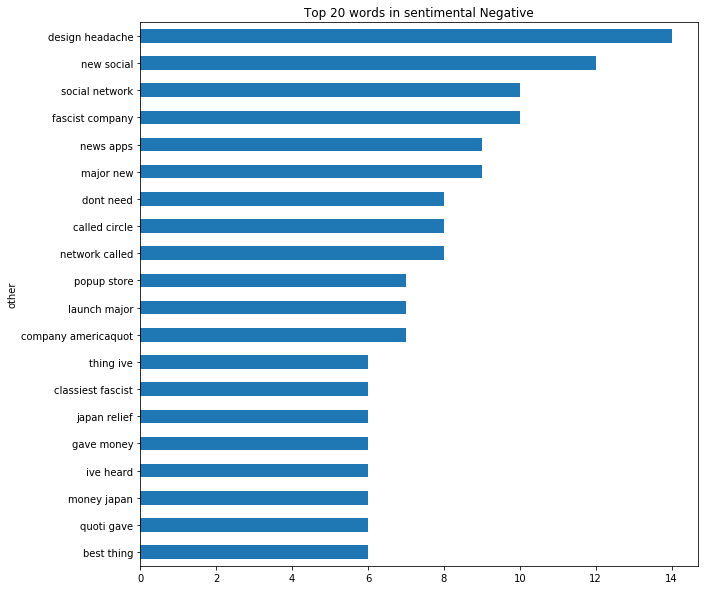

In [0]:
common_words = get_top_n_bigram(sent_0['other'], 20)
df1 = pd.DataFrame(common_words, columns = ['other' , 'count'])
f, ax = plt.subplots(figsize=(10, 10))
plt.title('Top 20 words in sentimental Negative')
df1.groupby('other').sum()['count'].sort_values().plot(kind='barh')

Text(0.5, 1.0, 'Top 20 words in Neutral Sentiment')

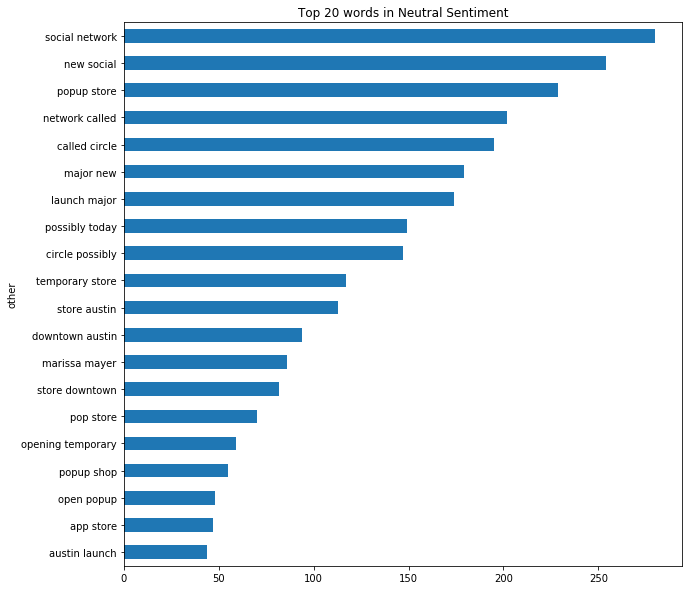

In [0]:
common_words = get_top_n_bigram(sent_1['other'], 20)
df1 = pd.DataFrame(common_words, columns = ['other' , 'count'])
f, ax = plt.subplots(figsize=(10, 10))
plt.title('Top 20 words in Neutral Sentiment')
df1.groupby('other').sum()['count'].sort_values().plot(kind='barh')

Text(0.5, 1.0, 'Top 20 words in Positive sentiment')

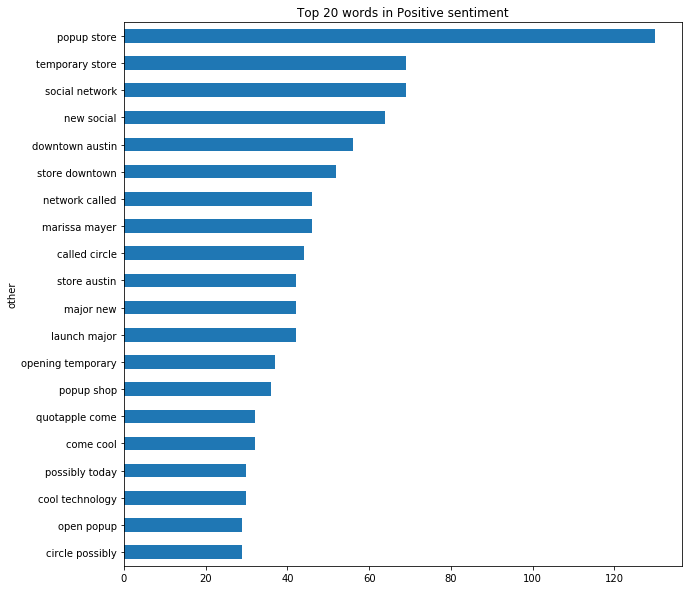

In [0]:
common_words = get_top_n_bigram(sent_2['other'], 20)
df1 = pd.DataFrame(common_words, columns = ['other' , 'count'])
f, ax = plt.subplots(figsize=(10, 10))
plt.title('Top 20 words in Positive sentiment')
df1.groupby('other').sum()['count'].sort_values().plot(kind='barh')

Text(0.5, 1.0, 'Top 20 words in Cant tell sentiment')

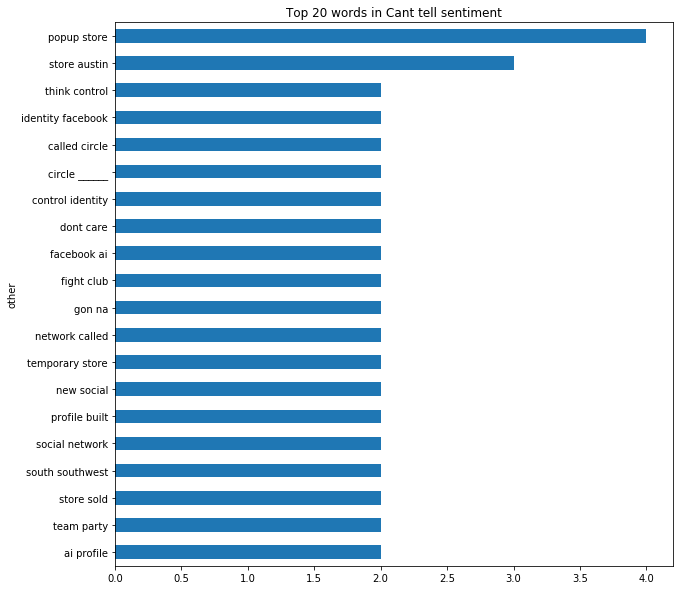

In [0]:
common_words = get_top_n_bigram(sent_3['other'], 20)
df1 = pd.DataFrame(common_words, columns = ['other' , 'count'])
f, ax = plt.subplots(figsize=(10, 10))
plt.title('Top 20 words in Cant tell sentiment')
df1.groupby('other').sum()['count'].sort_values().plot(kind='barh')

In [0]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


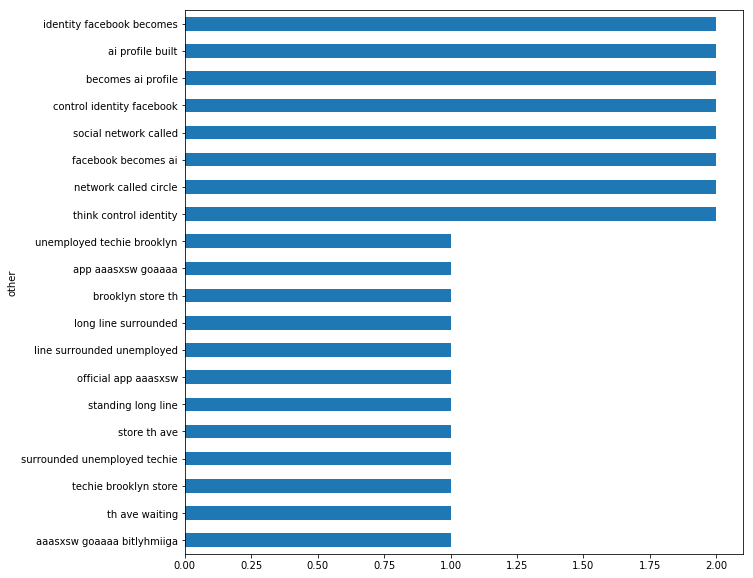

In [0]:
common_words = get_top_n_trigram(sent_3['other'], 20)
df5 = pd.DataFrame(common_words, columns = ['other' , 'count'])
f, ax = plt.subplots(figsize=(10, 10))
df5.groupby('other').sum()['count'].sort_values().plot(kind='barh')

In [0]:
train_fe = feature_engineering(train)

train_tweet = preprocess(train_fe) 
test_tweet  = preprocess(test) 

In [0]:
print(train_tweet.shape,test_tweet.shape)

(7273, 9) (1819, 2)


In [0]:
print("Preprocessed Dataframe" )
train_tweet.head()

Preprocessed Dataframe


,tweet,sentiment,num_punc,num_words,num_unique_words,num_chars,num_words_nostop,num_stop,cleaned
0,#sxswnui #sxsw #apple defining language of tou...,1,3,12,12,89,10,2,sxswnui sxsw apple defining language touch dif...
1,Learning ab Google doodles! All doodles should...,1,8,19,19,143,15,4,learning ab google doodle doodle light funny a...
2,one of the most in-your-face ex. of stealing t...,2,12,22,19,132,15,7,one inyourface ex stealing show yr quotat sxsw...
3,This iPhone #SXSW app would b pretty awesome i...,0,5,19,19,125,15,4,iphone sxsw app would pretty awesome didnt cra...
4,Line outside the Apple store in Austin waiting...,1,3,14,13,77,10,4,line outside apple store austin waiting new ip...


In [0]:
test_tweet.head()

,tweet,cleaned
0,Audience Q: What prototyping tools do you use?...,audience prototyping tool use sketchbookssharp...
1,At SXSW? Send Your Best Photos &amp; Videos to...,sxsw send best photo amp video citizen_journal...
2,@mention and here's a pic of you winning your...,here pic winning ipad unsix sxsw cc
3,Google Marissa Mayer: mobile phone as a cursor...,google marissa mayer mobile phone cursor physi...
4,#SXSW Google maps is even cooler than I thought,sxsw google map even cooler thought


# **Baseline Model and Feature Engineering**

## **Applying a baseline model**

In [0]:
def xy_separator(df):
  X = df.drop('sentiment', axis=1)
  y = df['sentiment']
  return X,y

X_train_data, y_train_data = xy_separator(train_tweet)
X_test_data = test_tweet

In [0]:
def run_model(dataframe,
              target,
              vectorizer=TfidfVectorizer(ngram_range=(1, 2), max_df=0.9, min_df=0.02),
              model=MultinomialNB()
             ):
    '''
    Performs model training and validate using f1-score
    '''
    X = dataframe
    y = target
    vect = vectorizer
    
    # splitting data into training and validation set
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0, test_size=0.3)
    
    # Vectorize
    vector = vect.fit(X_train['cleaned'])
    X_train_vect = vector.transform(X_train['cleaned']).toarray()
    X_valid_vect = vector.transform(X_valid['cleaned']).toarray()
    
    # Fit and predict
    model.fit(X_train_vect, y_train)  
    y_pred = model.predict(X_valid_vect)  
    
    #validation using f1-score
    c_report = metrics.classification_report(y_valid, y_pred)
    print('classification report: \n', c_report)
    F1_score = f1_score(y_valid, y_pred,average='weighted')
    print('F1_score: ',F1_score) 
    
    return F1_score, y_pred

In [0]:
models = [MultinomialNB, GaussianNB,LogisticRegression,DecisionTreeClassifier, RandomForestClassifier]
vectorizers = [TfidfVectorizer, CountVectorizer]
for vectorizer in vectorizers:
  vectorizer = vectorizer(max_df=0.9, min_df=0.02)
  for model in models:
      # run model
      model = model()
      F1_score, y_pred = run_model(X_train_data, y_train_data, vectorizer = vectorizer, model = OneVsRestClassifier(model)) 
      print('On Model - \n'+str(model),'\nwith Vectorizer - \n'+str(vectorizer))
      print('===='*20)

classification report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       137
           1       0.61      0.94      0.74      1291
           2       0.53      0.14      0.22       724
           3       0.00      0.00      0.00        30

    accuracy                           0.60      2182
   macro avg       0.29      0.27      0.24      2182
weighted avg       0.54      0.60      0.51      2182

F1_score:  0.5135929724169395
On Model - 
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) 
with Vectorizer - 
TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.9, max_features=None,
                min_df=0.02, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)

#  Handeling Data Imbalance with Grid-Search & Hyperparameter Tuning 

## **1. Grid Search using Logistic Regression**

In [0]:
def grid_search_log_reg(dataframe,target):
    X = dataframe
    y = target
    tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=0.01)
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # TF-IDF feature matrix
    tfidf_vectorizer.fit(X_train['cleaned'])
    X_train_vect = tfidf_vectorizer.transform(X_train['cleaned']).toarray()
    X_valid_vect = tfidf_vectorizer.transform(X_valid['cleaned']).toarray()
    print("X_train_vect shape befor smote: ",X_train_vect.shape)
    
    # SMOTE to handle data imbalance
    smote = SMOTE(kind='regular')
    X_train_vect_sm, y_train_sm =  smote.fit_sample(X_train_vect, y_train)
    print("X_train_vect_sm shape after smote: ",X_train_vect_sm.shape)
    
    log_reg = LogisticRegression()
    
    param_grid = { 
                  'C' : np.logspace(-5, 8, 15)
                 }
    grid_search_model = GridSearchCV(log_reg, param_grid=param_grid)
    
    grid_search_model.fit(X_train_vect_sm, y_train_sm)
    y_pred = grid_search_model.predict(X_valid_vect) 
    
    #validation using f1-score
    c_report = metrics.classification_report(y_valid, y_pred)
    print('classification report: \n', c_report)
    F1_score = f1_score(y_valid, y_pred,average='weighted')
    print('F1_score: ',F1_score) 
    
    return grid_search_model.best_params_

grid_search_log_reg_best_model = grid_search_log_reg(X_train_data,y_train_data)

X_train_vect shape befor smote:  (5091, 124)
X_train_vect_sm shape after smote:  (12036, 124)
classification report: 
               precision    recall  f1-score   support

           0       0.08      0.19      0.11       138
           1       0.72      0.43      0.54      1301
           2       0.47      0.42      0.44       706
           3       0.02      0.27      0.04        37

    accuracy                           0.40      2182
   macro avg       0.32      0.32      0.28      2182
weighted avg       0.59      0.40      0.47      2182

F1_score:  0.4691893551454501


## **2. Grid Search on Random Forest model**

In [580]:
def grid_search_rf_clf(dataframe,target):
    X = dataframe
    y = target
    
    tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=0.01, max_features=1000)

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # TF-IDF feature matrix
    tfidf_vectorizer.fit(X_train['cleaned'])
    X_train_vect = tfidf_vectorizer.transform(X_train['cleaned']).toarray()
    X_valid_vect = tfidf_vectorizer.transform(X_valid['cleaned']).toarray()
    
    rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1, class_weight="balanced")
    param_grid = { 
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy'],
    'n_estimators' : [50, 100, 200]  
    }
    grid_search_model = GridSearchCV(rf_clf, param_grid=param_grid)
    
    grid_search_model.fit(X_train_vect, y_train)
    y_pred = grid_search_model.predict(X_valid_vect) 
    
    
    #validation using f1-score
    c_report = metrics.classification_report(y_valid, y_pred)
    print('classification report: \n', c_report)
    F1_score = f1_score(y_valid, y_pred,average='weighted')
    print('F1_score: ',F1_score) 
    
    return grid_search_model.best_params_
  
grid_search_rf_clf_best_model = grid_search_rf_clf(X_train_data,y_train_data)

classification report: 
               precision    recall  f1-score   support

           0       0.13      0.42      0.20       138
           1       0.71      0.51      0.59      1301
           2       0.46      0.47      0.47       706
           3       0.03      0.05      0.04        37

    accuracy                           0.49      2182
   macro avg       0.33      0.36      0.32      2182
weighted avg       0.58      0.49      0.52      2182

F1_score:  0.5187273510022221


# **Ensembling**

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier


def ensemble(dataframe,target):
    X = dataframe
    y = target
    
    tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=0.01, max_features=1000)
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)
     
    # TF-IDF feature matrix
    tfidf_vectorizer.fit(X_train['cleaned'])
    X_train_vect = tfidf_vectorizer.transform(X_train['cleaned']).toarray()
    X_valid_vect = tfidf_vectorizer.transform(X_valid['cleaned']).toarray()
   
    model1 = RandomForestClassifier(random_state=0, n_jobs=-1, 
                                    class_weight="balanced", 
                                    criterion = 'gini',max_depth= 8,
                                    max_features = 'auto', n_estimators = 200
                                    )
    model2 = MultinomialNB()
    model3 = LogisticRegression(class_weight="balanced")
    
    model = VotingClassifier(estimators=[('rf', model1),('nb', model2), ('lr', model3)], voting='soft')
    
    model.fit(X_train_vect,y_train)
    y_pred = model.predict(X_valid_vect) 
    
    #validation using f1-score
    c_report = metrics.classification_report(y_valid, y_pred)
    print('classification report: \n', c_report)
    F1_score = f1_score(y_valid, y_pred,average='weighted')
    print('F1_score: ',F1_score) 
    
    return tfidf_vectorizer, model

ensemble(X_train_data,y_train_data)

classification report: 
               precision    recall  f1-score   support

           0       0.25      0.06      0.09       138
           1       0.66      0.82      0.73      1301
           2       0.50      0.38      0.43       706
           3       0.00      0.00      0.00        37

    accuracy                           0.62      2182
   macro avg       0.35      0.32      0.32      2182
weighted avg       0.57      0.62      0.58      2182

F1_score:  0.5840172616374911


(TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.float64'>, encoding='utf-8',
                 input='content', lowercase=True, max_df=0.9, max_features=1000,
                 min_df=0.01, ngram_range=(1, 1), norm='l2', preprocessor=None,
                 smooth_idf=True, stop_words=None, strip_accents=None,
                 sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=None, use_idf=True, vocabulary=None),
 VotingClassifier(estimators=[('rf',
                               RandomForestClassifier(bootstrap=True,
                                                      class_weight='balanced',
                                                      criterion='gini',
                                                      max_depth=8,
                                                      max_features='auto',
                                                      max_leaf_nodes=None,
                   

# **Final Submission**

In [0]:
print(X_test.head())
final_vectrizer, final_model = ensemble(X_train_data, y_train_data)
X_test_vect = final_vectrizer.transform(X_test_data['cleaned']).toarray()

final_pred = final_model.predict(X_test_vect)


                                               tweet  ...  num_stop
0  Audience Q What prototyping tool use Sketchboo...  ...         2
1  At Send Your Best Photos amp Videos ... citize...  ...         0
2                  's pic winning ipad unsix sxsw cc  ...         5
3  Google Marissa Mayer mobile phone cursor physi...  ...         6
4                   Google map even cooler I thought  ...         2

[5 rows x 7 columns]
classification report: 
               precision    recall  f1-score   support

           0       0.25      0.06      0.09       138
           1       0.66      0.82      0.73      1301
           2       0.50      0.38      0.43       706
           3       0.00      0.00      0.00        37

    accuracy                           0.62      2182
   macro avg       0.35      0.32      0.32      2182
weighted avg       0.57      0.62      0.58      2182

F1_score:  0.5840172616374911


In [0]:
#Create a  DataFrame with the tweet_id and our prediction regarding sentiment
submission = pd.DataFrame({'tweet_id':test_data['tweet_id'],'Sentiment':final_pred})
print(submission.shape)
submission.to_csv('submission.csv', index=False)
files.download('submission.csv')

(1819, 2)
